# Detect Bird from photo

The basic steps we'll take are:
* Use DuckDuckGO to search for images of "bird photos"
* Use DuckDuckGo to search images of "forest photos"
* Fin-tune a pretrained neural network to recognize these two groups
* try running this model on a picture of a bird and see if it works.

In [8]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images = 200):
    return L(DDGS().images(keywords, max_results = max_images)).itemgot('image')

In [9]:
#Search for images of birds
urls = search_images("bird photos", max_images=1)

urls[0]

C:\Users\davor\AppData\Local\Temp\ipykernel_25300\1715108970.py:5: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results = max_images)).itemgot('image')


'https://images.pexels.com/photos/97533/pexels-photo-97533.jpeg?cs=srgb&dl=animal-avian-bird-97533.jpg&fm=jpg'

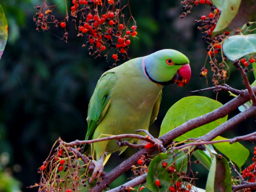

In [10]:
#Downlad the image
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

In [12]:
#Download "forest photos"
download_url(search_images("forest photos", max_images=1)[0], 'forest.jpg', show_progress=True)

C:\Users\davor\AppData\Local\Temp\ipykernel_25300\1715108970.py:5: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results = max_images)).itemgot('image')


Path('forest.jpg')

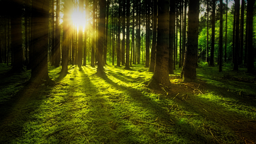

In [13]:
Image.open('forest.jpg').to_thumb(256, 256)

In [14]:
#Dowload images of both birds and forests
searches = 'forest', 'bird'
path = Path('bird_or_not')

from time import sleep

for s in searches:
    #specify the path
    dest = (path/s)
    #Create the directory
    dest.mkdir(exist_ok=True, parents=True)
    #Downloaf the images
    download_images(dest, urls=search_images(f"{s} photo"))
    sleep(10) #Sleep between searches to avoid over-loading the server
    download_images(dest, urls=search_images(f"{s} sun photo"))
    sleep(10)
    download_images(dest, urls=search_images(f"{s} shade photo")) 
    sleep(10)
    resize_images(path/s, max_size=400, dest=path/s)

C:\Users\davor\AppData\Local\Temp\ipykernel_25300\1715108970.py:5: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results = max_images)).itemgot('image')
C:\Users\davor\AppData\Local\Temp\ipykernel_25300\1715108970.py:5: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results = max_images)).itemgot('image')
C:\Users\davor\AppData\Local\Temp\ipykernel_25300\1715108970.py:5: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results = max_images)).itemgot('image')
C:\Users\davor\AppData\Local\Temp\ipykernel_25300\1715108970.py:5: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results = ma

# Step 2: Train the model

In [16]:
#Remove images that failed to download
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

124

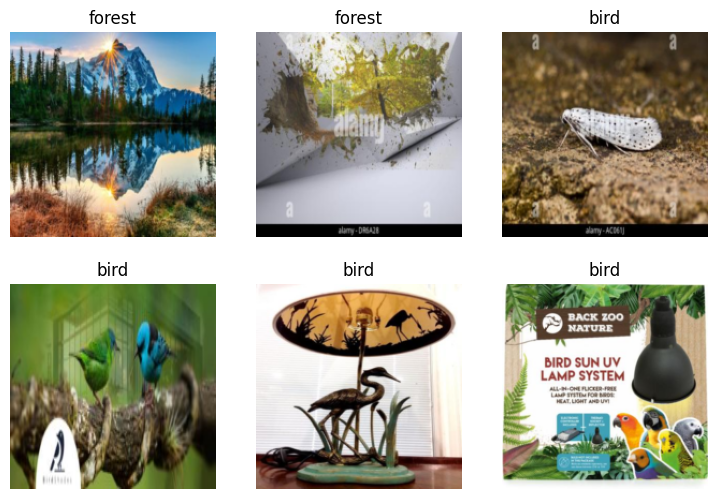

In [18]:
#Create DataLoaders
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = [Resize(192, method="squish")]
).dataloaders(path)

dls.show_batch(max_n=6)

In [20]:
#train the mode
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\davor/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:28<00:00, 1.65MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.755578,0.540301,0.140704,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.284727,0.387383,0.140704,00:31
1,0.175453,0.451306,0.120603,00:31
2,0.128782,0.465022,0.105528,00:31


# Step 3: Use the model

In [25]:
#Check the model against the first image
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a :{is_bird}.")
print(f"Probability of being a bird: {probs[0]:.4f}")

This is a :bird.
Probability of being a bird: 0.9999
